In this exercise we will develop an in depth understanding of the defensive distillation defense method against adversarial examples.
Start by reading about this method - how does it work, what is the idea behind it etc.
Be prepared to discuss this in depth with your instructor

** you do **not** need to keep the notebook in this order just make sure that you preform all the needed sections and keep a good record of any results and conclusions

1. train a CNN classifer on MNIST, you are welcome to use the code from the attack exercise
2. attack the trained model with FGSM, TGSM, BIM & PGD (you can use the TF only implementation for more efficiency)
3. implement the defensive distillation approach and train a new classifier using it
4. attack the new classifier with the same attacks as before - did you notice any differences?
5. randomly choose 2 classes from the MNIST dataset, and repeat the whole process of training a classifier regulary and with defensive distillation and attacking it
6. make 4 plots describing the following regarding your classifiers  
    a. you will have 2 plots for each classifier (regular and defensive distil.)  
    b. for each classifier one plot will describe logits and one probabilities  
    c. each plot will be a 2d-scatter plot describing the logit (or prob) value of one class vs the other, where each point represents an input image  
    d. add the line y=x and plot the values for only one class of the Ground Truth  
    e. look at the received plots, did the defense method acheive it's goal?  
    
**BONUS** repeat the process for a regular classifier with a high temperature, where the results similar or different? how so?

In [40]:
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

# Enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [112]:
from keras.layers import Layer
K = keras.backend

class DivideLayer(Layer):
    def __init__(self, temperature=1, **kwargs):
        self.temperature = temperature
        super(DivideLayer, self).__init__(**kwargs)

    def call(self, inputs, training=None):
        if training:
            return  inputs / self.temperature
        return inputs

In [113]:
def build_mnist_model(n_classes, temperature=1):
    
    activation = 'relu'
    img_rows, img_cols, img_colors = 28, 28, 1
    
    model = keras.Sequential()
    model.add(layers.Conv2D(8, kernel_size=(3, 3), 
                            input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(n_classes))
#     model.add(layers.Lambda(lambda inputs: inputs / temperature))
    model.add(DivideLayer(temperature))
    model.add(layers.Activation('softmax', name='y_pred'))
              
    return model

In [114]:
def normalize(x_train,x_test):
    x_train -= x_train.min()
    x_train /= x_train.max()
    x_test -= x_test.min()
    x_test /= x_test.max()
    
    return x_train, x_test

In [115]:
num_classes = 10

img_rows, img_cols, img_colors = 28, 28, 1
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)

train_images, test_images = normalize(train_images, test_images)
    
train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

In [116]:
print('train_images', train_images.shape)
print('test_images', test_images.shape)
print('train_labels', train_labels.shape)
print('test_labels', test_labels.shape)

train_images (60000, 28, 28, 1)
test_images (10000, 28, 28, 1)
train_labels (60000, 10)
test_labels (10000, 10)


In [149]:
from keras.callbacks import EarlyStopping

def train_model(train_images, train_labels, test_images, test_labels, temperature,
                batch_size=128, maxepoches=12, learning_rate=0.1, lr_decay=1e-6, lr_drop=20):
    
    n_classes = train_labels.shape[1]
    
    def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))
    reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)
    es = EarlyStopping(monitor='val_categorical_accuracy', mode='max', verbose=1, patience=3)
    
    model = build_mnist_model(n_classes, temperature=temperature)
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=[keras.metrics.CategoricalAccuracy()])
    
    history = model.fit(train_images, train_labels,
                        batch_size=batch_size,
                        epochs=maxepoches,
                        verbose=1,
                        validation_data=(test_images, test_labels),
                        callbacks=[reduce_lr, es])
    return model

In [121]:
def train_distillation(train_images, train_labels, test_images, test_labels, temperature):
    
    teacher = train_model(train_images, train_labels, test_images, test_labels, temperature)

    train_logits = teacher.predict(train_images)
    test_logits = teacher.predict(test_images)
    
    student = train_model(train_images, train_logits, test_images, test_logits, temperature)

    return teacher, student

In [144]:
teacher, student = train_distillation(train_images, train_labels, test_images, test_labels, 
                                     temperature=5)

Epoch 1/12
469/469 [==============================] - 17s 36ms/step - loss: 1.3498 - categorical_accuracy: 0.5392 - val_loss: 0.7639 - val_categorical_accuracy: 0.8967
Epoch 2/12
469/469 [==============================] - 17s 35ms/step - loss: 0.5608 - categorical_accuracy: 0.8216 - val_loss: 0.6962 - val_categorical_accuracy: 0.9162
Epoch 3/12
469/469 [==============================] - 17s 35ms/step - loss: 0.4814 - categorical_accuracy: 0.8504 - val_loss: 0.6397 - val_categorical_accuracy: 0.9252
Epoch 4/12
469/469 [==============================] - 16s 35ms/step - loss: 0.4435 - categorical_accuracy: 0.8638 - val_loss: 0.5894 - val_categorical_accuracy: 0.9315
Epoch 00004: early stopping
Epoch 1/12
469/469 [==============================] - 18s 38ms/step - loss: 1.2484 - categorical_accuracy: 0.5944 - val_loss: 0.2351 - val_categorical_accuracy: 0.9463
Epoch 2/12
469/469 [==============================] - 17s 37ms/step - loss: 0.3805 - categorical_accuracy: 0.8694 - val_loss: 0.1656

## Attack teacher and student

In [123]:
def TestAttack(model, adv_images, orig_images, true_labels, target_labels=None, targeted=False):
    adv_images = adv_images.numpy()
    score = model.evaluate(adv_images, true_labels, verbose=0)
    
    print('Test loss: {:.2f}'.format(score[0]))
    print('Successfully moved out of source class: {:.2f}'.format( 1 - score[1]))
    
    if targeted:
        score = model.evaluate(adv_images, target, verbose=0)
        print('Test loss: {:.2f}'.format(score[0]))
        print('Successfully perturbed to target class: {:.2f}'.format(score[1]))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))
    
    index = 10
    img = adv_images[index].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

In [124]:
def FastGradientSignMethod(model, input_image, input_label, eps=0.3):
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)

    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    adv_x = input_image + eps*signed_grad
    
    return adv_x

In [125]:
from tqdm import tqdm

def BasicIterativeMethod(model, input_image, input_label, epsilon=0.1, iter_eps = 0.05, 
                         iterations=10, min_x=0.0, max_x=1.0):
    
    def step_targeted_attack(model, input_image, input_label, epsilon, min_x, max_x):
        loss_object = tf.keras.losses.CategoricalCrossentropy()
        
        with tf.GradientTape() as tape:
            tape.watch(input_image)
            prediction = model(input_image)
            loss = loss_object(input_label, prediction)

        gradient = tape.gradient(loss, input_image)
        signed_grad = tf.sign(gradient)
        adv_x = input_image + epsilon*signed_grad
        
        adv_x = tf.clip_by_value(adv_x, min_x, max_x)
        return tf.stop_gradient(adv_x)
    

    adv_out = input_image
    for i in tqdm(range(iterations)):
        adv_out = step_targeted_attack(model, adv_out, input_label, 
                                       iter_eps, min_x, max_x)
        
    return adv_out

In [126]:
test_images = tf.convert_to_tensor(test_images)

# Teacher Attack

Test loss: 172.49
Successfully moved out of source class: 0.39
Mean perturbation distance: 1.82


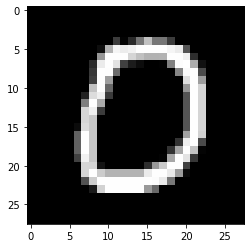

In [145]:
adv_images = FastGradientSignMethod(teacher, test_images, test_labels, eps=0.3)
TestAttack(teacher, adv_images, test_images.numpy(), test_labels, targeted=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:12<00:00,  2.41s/it]


Test loss: 6.60
Successfully moved out of source class: 0.39
Mean perturbation distance: 0.04


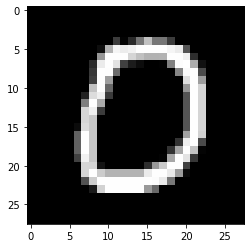

In [146]:
adv_images = BasicIterativeMethod(teacher, test_images, test_labels, 
                                  iterations = 30, epsilon=4.0, iter_eps = 0.01)
TestAttack(teacher, adv_images, test_images.numpy(), test_labels, targeted=False)

# Student Attack

Test loss: 14.08
Successfully moved out of source class: 0.28
Mean perturbation distance: 0.07


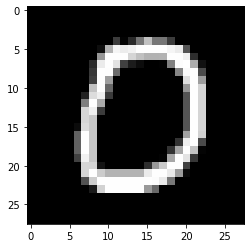

In [147]:
adv_images = FastGradientSignMethod(student, test_images, test_labels, eps=0.3)
TestAttack(student, adv_images, test_images.numpy(), test_labels, targeted=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:12<00:00,  2.43s/it]


Test loss: 4.98
Successfully moved out of source class: 0.28
Mean perturbation distance: 0.02


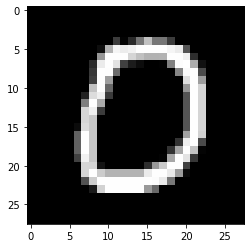

In [148]:
adv_images = BasicIterativeMethod(student, test_images, test_labels, 
                                  iterations = 30, epsilon=4.0, iter_eps = 0.01)
TestAttack(student, adv_images, test_images.numpy(), test_labels, targeted=False)

## Binary classification

In [150]:
wanted_classes = [0, 8]
(_, train_labels_), (_, test_labels_) = keras.datasets.mnist.load_data()

train_mask = (train_labels_ == wanted_classes[0]) | (train_labels_ == wanted_classes[1]) 
test_mask = (test_labels_ == wanted_classes[0]) | (test_labels_ == wanted_classes[1])

train_labels_2, train_images_2 = train_labels[train_mask], train_images[train_mask]
test_labels_2, test_images_2 = test_labels[test_mask], test_images[test_mask]

train_labels_2, test_labels_2 = train_labels_2[:, wanted_classes], test_labels_2[:, wanted_classes]

print('train_labels_2', train_labels_2.shape)
print('test_labels_2', test_labels_2.shape)
print('train_images_2', train_images_2.shape)
print('test_images_2', test_images_2.shape)

train_labels_2 (11774, 2)
test_labels_2 (1954, 2)
train_images_2 (11774, 28, 28, 1)
test_images_2 (1954, 28, 28, 1)


In [172]:
teacher_2, student_2 = train_distillation(train_images_2, 
                                          train_labels_2, test_images_2, test_labels_2, 
                                         temperature=2)

Epoch 1/12
92/92 [==============================] - 4s 39ms/step - loss: 0.4191 - categorical_accuracy: 0.8666 - val_loss: 0.0666 - val_categorical_accuracy: 0.9744
Epoch 2/12
92/92 [==============================] - 3s 35ms/step - loss: 0.0960 - categorical_accuracy: 0.9691 - val_loss: 0.0428 - val_categorical_accuracy: 0.9887
Epoch 3/12
92/92 [==============================] - 3s 35ms/step - loss: 0.0610 - categorical_accuracy: 0.9804 - val_loss: 0.0408 - val_categorical_accuracy: 0.9913
Epoch 4/12
92/92 [==============================] - 4s 39ms/step - loss: 0.0491 - categorical_accuracy: 0.9845 - val_loss: 0.0407 - val_categorical_accuracy: 0.9913
Epoch 5/12
92/92 [==============================] - 3s 35ms/step - loss: 0.0467 - categorical_accuracy: 0.9839 - val_loss: 0.0409 - val_categorical_accuracy: 0.9918
Epoch 6/12
92/92 [==============================] - 3s 35ms/step - loss: 0.0428 - categorical_accuracy: 0.9863 - val_loss: 0.0395 - val_categorical_accuracy: 0.9918
Epoch 7/12

In [158]:
test_images_2 = tf.convert_to_tensor(test_images_2)

## Teacher Attack

Test loss: 3.54
Successfully moved out of source class: 0.42
Mean perturbation distance: 0.12


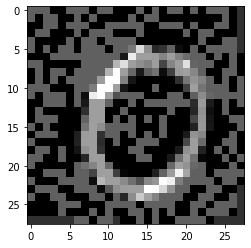

In [176]:
adv_images = FastGradientSignMethod(teacher_2, test_images_2, test_labels_2, eps=0.3)
TestAttack(teacher_2, adv_images, test_images_2.numpy(), test_labels_2, targeted=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  2.00it/s]


Test loss: 0.84
Successfully moved out of source class: 0.04
Mean perturbation distance: 0.00


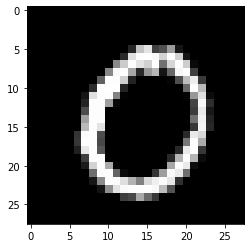

In [160]:
adv_images = BasicIterativeMethod(teacher_2, test_images_2, test_labels_2, 
                                  iterations = 30, epsilon=4.0, iter_eps = 0.05)
TestAttack(teacher_2, adv_images, test_images_2.numpy(), test_labels_2, targeted=False)

## Student Attack

Test loss: 3.68
Successfully moved out of source class: 0.30
Mean perturbation distance: 0.09


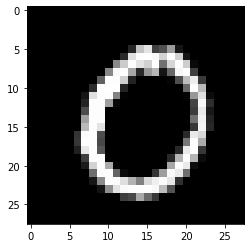

In [177]:
adv_images = FastGradientSignMethod(student_2, test_images_2, test_labels_2, eps=0.3)
TestAttack(student_2, adv_images, test_images_2.numpy(), test_labels_2, targeted=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.94it/s]


Test loss: 0.55
Successfully moved out of source class: 0.03
Mean perturbation distance: 0.00


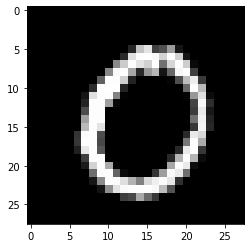

In [162]:
adv_images = BasicIterativeMethod(student_2, test_images_2, test_labels_2, 
                                  iterations = 30, epsilon=4.0, iter_eps = 0.05)
TestAttack(student_2, adv_images, test_images_2.numpy(), test_labels_2, targeted=False)

## Visualization

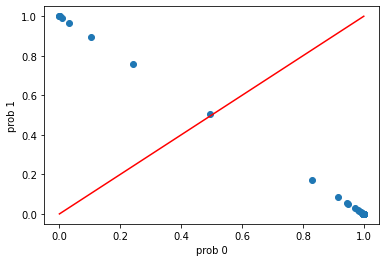

In [185]:
one_class_test_images = test_images[test_labels[:,0]==1]
prob = student_2.predict(one_class_test_images)

plt.scatter(prob[:, 0], prob[:, 1])
plt.plot([prob.min(), prob.max()], [prob.min(), prob.max()], color='r')
plt.xlabel("prob 0")
plt.ylabel("prob 1")
plt.show()

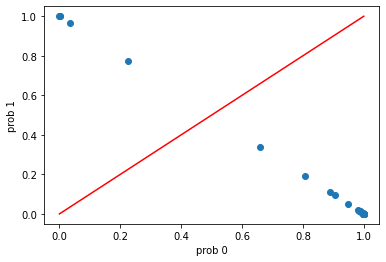

In [186]:
prob = teacher_2.predict(one_class_test_images)

plt.scatter(prob[:, 0], prob[:, 1])
plt.plot([prob.min(), prob.max()], [prob.min(), prob.max()], color='r')
plt.xlabel("prob 0")
plt.ylabel("prob 1")
plt.show()